In [25]:
import random
import folium
from tqdm import tqdm

import numpy as np
import pandas as pd
pd.set_option('mode.chained_assignment', None)

from sklearn.cluster import DBSCAN

import statsmodels.api as sm
from sklearn.utils.class_weight import compute_sample_weight

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

from statsmodels.stats.outliers_influence import variance_inflation_factor

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("C:/Users/Настя/YandexDisk-n4skolesnikova/HSE 4th year/Graduation Thesis/data/ACCIDENT_LEVEL_DATA.csv")
df = df.drop('Unnamed: 0', axis=1)
print(df.shape)
df.head()

(440127, 75)


,REGION,DATE,COORD_L,COORD_W,road_name,road_category,n_VEHICLES,n_PARTICIPANTS,ID,n_DEATHS,...,severity,YEAR,MONTH,WEEKDAY,SEASON,is_WEEKEND,HOUR,is_NIGHT,is_PEAK_HOUR,is_toll
0,1,31.01.2015,81.151944,53.740000,Романово - Завьялово - Баево - Камень-на-Оби,5.0,1,3,161242174,0,...,2,2015,1,5,1,1,9,0,1,0
1,1,30.01.2015,85.018056,51.684444,Куяган - Куяча - Тоурак,6.0,2,3,161105683,0,...,2,2015,1,4,1,0,14,0,0,0
2,1,30.01.2015,81.250000,53.818056,Барнаул - Камень-на-Оби - граница Новосибирско...,5.0,2,3,161763431,0,...,1,2015,1,4,1,0,17,0,1,0
3,1,24.01.2015,51.000000,84.000000,Быканов Мост - Солоновка - Солонешное - границ...,7.0,1,2,160331994,0,...,1,2015,1,5,1,1,19,0,0,0
4,1,23.01.2015,84.000000,53.000000,Быканов Мост - Солоновка - Солонешное - границ...,7.0,1,2,160213415,1,...,3,2015,1,4,1,0,21,0,0,0


In [4]:
toll_roads_df = df[df['is_toll'] == 1]
free_roads_df = df[df['is_toll'] == 0]

dbscan_toll = DBSCAN(eps=0.2/6371.0, min_samples=5, metric="haversine")
toll_roads_df.loc[:, "cluster"] = dbscan_toll.fit_predict(np.radians(toll_roads_df[["COORD_W", "COORD_L"]].values))

dbscan_free = DBSCAN(eps=0.3/6371.0, min_samples=5, metric="haversine")    # larger eps for free ones as more observations
free_roads_df.loc[:, "cluster"] = dbscan_free.fit_predict(np.radians(free_roads_df[["COORD_W", "COORD_L"]].values))

df = pd.concat([toll_roads_df, free_roads_df], ignore_index=True)

In [37]:
# voronezh_center = [51.6608, 39.2003]
# m = folium.Map(location=voronezh_center, zoom_start=6)

# # Цвета для кластеров: красный для платных дорог, зелёный для бесплатных, серый для шума
# cluster_colors = {
#     1: "red",  # для платных дорог
#     0: "green",  # для бесплатных дорог
#     -1: "gray"  # шумовые точки
# }

# # Добавляем маркеры на карту
# for idx, row in df.iterrows():
#     # Определяем цвет в зависимости от дороги (is_toll)
#     if row["is_toll"] == 1:  # Платные дороги
#         color = "red"
#     elif row["is_toll"] == 0:  # Бесплатные дороги
#         color = "green"
#     else:  # Шумовые точки
#         color = "gray"

#     folium.CircleMarker(
#         location=[row["COORD_W"], row["COORD_L"]],
#         radius=4,
#         color=color,
#         fill=True,
#         fill_color=color,
#         fill_opacity=0.6
#     ).add_to(m)

# m

In [5]:
# Negative examples (clusters with label -1)
negative_examples = df[df["cluster"] == -1]

# Positive examples (clusters with labels 0, 1, 2, ...)
positive_examples = df[df["cluster"] != -1]

## Hypotheses testing

In [6]:
imsbalance = positive_examples['is_toll'].sum() / positive_examples.shape[0]
print(f"Class imbalance in hotspot dataset: {imsbalance}")

Class imbalance in hotspot dataset: 0.08205811707518727


In [7]:
sample_weights = compute_sample_weight(class_weight='balanced', y=positive_examples['is_toll'])
df_weighted = positive_examples.loc[positive_examples.index.repeat(sample_weights.round().astype(int))]

X = df_weighted[[
    'is_toll', 'n_VEHICLES', 'n_PARTICIPANTS',
    'n_drunk', 'guilty_exp_avg', 'cause_factors_cat',
    'exp_avg', 'guilty_share', 'lighting_cat', 'site_objects_cat', 
    'maneuver_violation', 'wrong_way', 'interference_violation',
    'impaired_driving', 'pedestrian_violation', 'n_front_drive',
    'vehicle_age_avg', 'road_rank_cat', 'TYPE_cat', 'adj_objects_cat'
]]

X = sm.add_constant(X)

y = df_weighted['severity']

model = sm.MNLogit(y, X)
result = model.fit()

print(result.summary())

Optimization terminated successfully.
         Current function value: 0.945342
         Iterations 6
                          MNLogit Regression Results                          
Dep. Variable:               severity   No. Observations:               197868
Model:                        MNLogit   Df Residuals:                   197826
Method:                           MLE   Df Model:                           40
Date:                Wed, 23 Apr 2025   Pseudo R-squ.:                 0.05396
Time:                        17:47:38   Log-Likelihood:            -1.8705e+05
converged:                       True   LL-Null:                   -1.9772e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
            severity=2       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     40.3186      1.586     25.417      0.000      37.210      

We have once again confirmed the hypothesis that the probability of a severe accident is higher on toll roads than on free roads.

Moreover, by comparing the coefficients for the `is_toll` feature between the model for the entire dataset (see the file `severity_hypotheses.ipynb`) and the model for hotspot areas, we can note that the coefficient for `is_toll` is significantly higher in the hotspot areas: for moderate severity accidents (`severity = 2`) — 0.3235, and for severe accidents (`severity = 3`) — 0.4115. In contrast, for all observations, the coefficients are considerably lower: 0.2609 for moderate severity and 0.2564 for severe accidents. This indicates that the influence of the `is_toll` feature on accident severity is stronger in hotspot areas compared to roads in general.

This leads us to the idea of developing a model that can predict accident hotspots based on coordinates and additional features.

### RandomForest

#### Predict hot spots based on __road features__

# Hot spot predictor model

The model works better with info about driver behavior on the roads and other accidents variables, but we must proceed from the fact that when opening a new section of road we have no information about accidents on it, so we will select features that reflect the geographical location and characteristics of the road section itself.

In [32]:
features = ["COORD_L", "COORD_W", "site_objects_cat", "road_rank_cat", "adj_objects_cat", 
            "traffic_changes_cat", "road_defects_cat", "cause_factors_cat", "road_category", 
            "street_rank_cat", "is_toll"]

X_model = df[features]

# Target variable: hotspots (1 = hotspot, 0 = not hotspot)
y_model = np.where(df["cluster"] != -1, 1, 0)

X_train, X_test, y_train, y_test = train_test_split(X_model, y_model, test_size=0.2, random_state=42)

rf_model_road = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model_road.fit(X_train, y_train)

y_pred = rf_model_road.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 (macro):", f1_score(y_test, y_pred, average='macro'))

Accuracy: 0.8376161588621543
F1 (macro): 0.8101451634169294


#### Predict hot spots based on __road features and conditions__

We can also approach the task by predicting hot spots under specific conditions, for example, by setting certain weather or temporal parameters. We will select the most informative features from the proposed list and use the Variance Inflation Factor (VIF) to check for multicollinearity, removing some features if necessary.

In [ ]:
conditions = ['road_surface_cat', 'lighting_cat', 'weather_cat', 'SEASON', 'is_WEEKEND', 'is_NIGHT', 'is_PEAK_HOUR', 'MONTH', 'WEEKDAY', 'YEAR']

X_vif = df[conditions]
vif = pd.DataFrame()
vif["feature"] = X_vif.columns
vif["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]

            feature        VIF
9              YEAR  23.869131
2       weather_cat  20.290597
0  road_surface_cat  10.554632
3            SEASON  10.043429
8           WEEKDAY   9.695555
7             MONTH   7.888668
4        is_WEEKEND   4.150945
1      lighting_cat   1.972666
5          is_NIGHT   1.681767
6      is_PEAK_HOUR   1.662838


C:\Users\Настя\AppData\Local\Temp\ipykernel_26400\2614426569.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


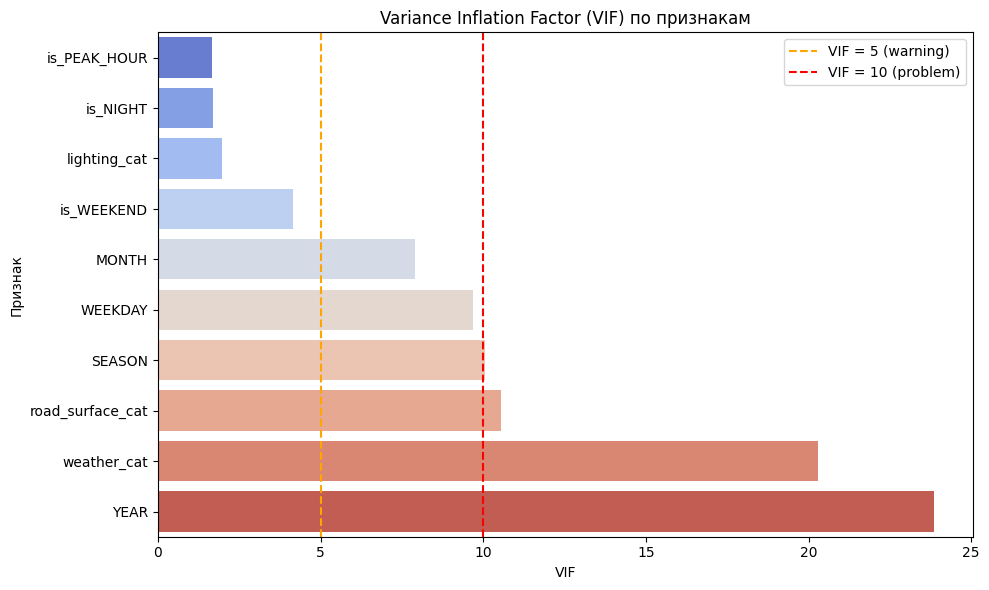

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(
    data=vif.sort_values(by="VIF", ascending=True),
    x="VIF",
    y="feature",
    palette="coolwarm"
)
plt.axvline(5, color='orange', linestyle='--', label='VIF = 5 (warning)')
plt.axvline(10, color='red', linestyle='--', label='VIF = 10 (problem)')
plt.title("Variance Inflation Factor (VIF) по признакам")
plt.xlabel("VIF")
plt.ylabel("Признак")
plt.legend()
plt.tight_layout()
plt.show()

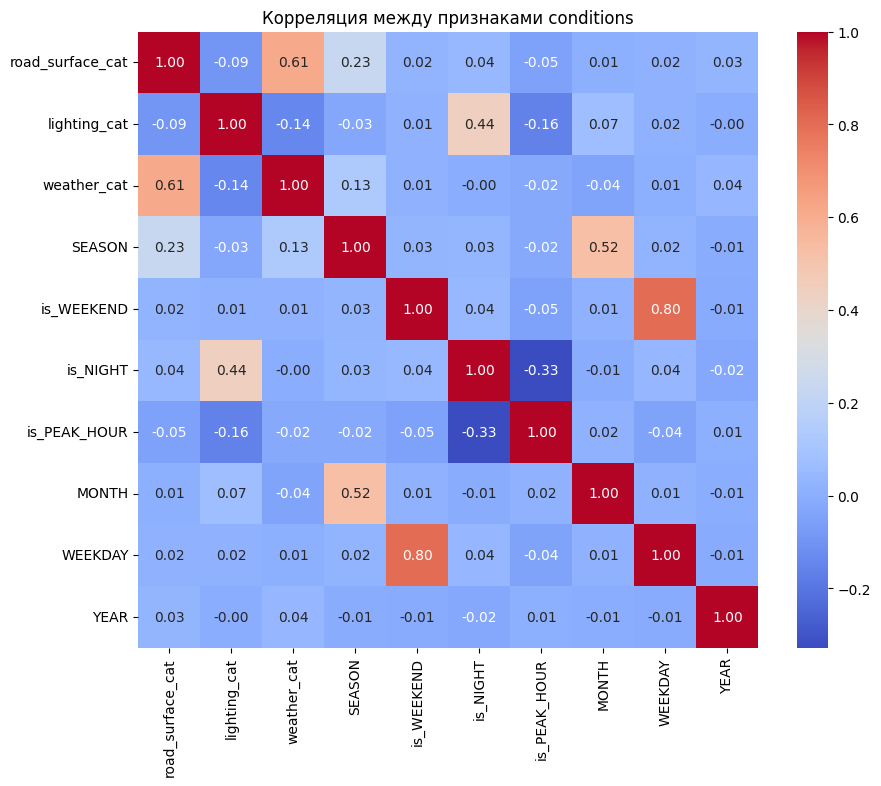

In [24]:
plt.figure(figsize=(10, 8))
sns.heatmap(df[conditions].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Корреляция между признаками conditions")
plt.show()

Based on the VIF analysis and the correlation matrix, we retain the following features:

In [ ]:
final_conditions = [
    'road_surface_cat',
    'lighting_cat',
    'weather_cat',
    'SEASON',
    'is_WEEKEND',
    'is_NIGHT',
    'is_PEAK_HOUR'
]

features.extend(final_conditions)

X_model = df[features]
y_model = np.where(df["cluster"] != -1, 1, 0)

X_train, X_test, y_train, y_test = train_test_split(X_model, y_model, test_size=0.2, random_state=42)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 (macro):", f1_score(y_test, y_pred, average='macro'))

Accuracy: 0.7950264694522073
F1 (macro): 0.7459124013986174


C:\Users\Настя\AppData\Local\Temp\ipykernel_26400\855097144.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feat_imp, y=feat_imp.index, palette='viridis')


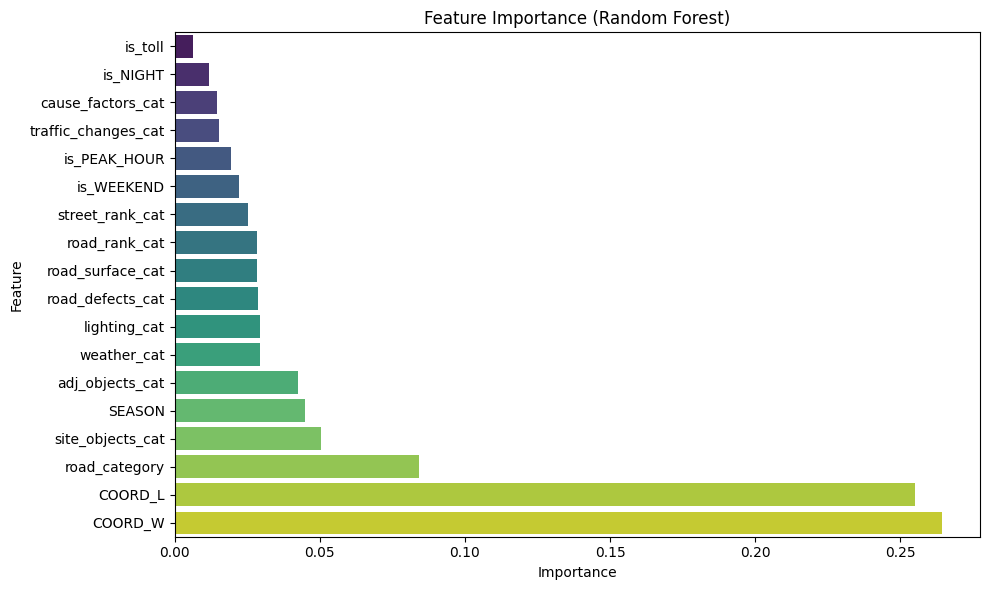

In [28]:
importances = rf_model.feature_importances_

feat_imp = pd.Series(importances, index=X_model.columns).sort_values(ascending=True)

plt.figure(figsize=(10, 6))
sns.barplot(x=feat_imp, y=feat_imp.index, palette='viridis')
plt.title("Feature Importance (Random Forest)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

In [30]:
important_features = feat_imp[feat_imp > 0.02].index.tolist()
important_features.extend(['is_toll'])
print("Chosen features:", important_features)

Chosen features: ['is_WEEKEND', 'street_rank_cat', 'road_rank_cat', 'road_surface_cat', 'road_defects_cat', 'lighting_cat', 'weather_cat', 'adj_objects_cat', 'SEASON', 'site_objects_cat', 'road_category', 'COORD_L', 'COORD_W', 'is_toll']


In [ ]:
X_model = df[important_features]
y_model = np.where(df["cluster"] != -1, 1, 0)

X_train, X_test, y_train, y_test = train_test_split(X_model, y_model, test_size=0.2, random_state=42)

rf_model_cond = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model_cond.fit(X_train, y_train)

y_pred = rf_model_cond.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 (macro):", f1_score(y_test, y_pred, average='macro'))

Accuracy: 0.7956626451275759
F1 (macro): 0.7501638200171326


Example of prediction:

In [10]:
new_data = pd.DataFrame({
    "COORD_L": [55.7558],
    "COORD_W": [37.6173],
    "site_objects_cat": [2],
    "road_rank_cat": [1],
    "adj_objects_cat": [3],
    "traffic_changes_cat": [0],
    "road_defects_cat": [1],
    "cause_factors_cat": [0],
    "road_category": [1],
    "is_toll": [0]
})

new_prediction = rf_model.predict(new_data)

if new_prediction[0] == 1:
    print("This is a hot spot (high-risk area).")
else:
    print("This is not a hot spot (low-risk area).")

This is not a hot spot (low-risk area).


In [11]:
m = folium.Map(location=[55.7558, 37.6173], zoom_start=10)

# If it is hot spot, the marker is red, if not, the marker is blue
color = "red" if new_prediction[0] == 1 else "blue"

folium.CircleMarker(
    location=[new_data["COORD_L"][0], new_data["COORD_W"][0]],
    radius=6,
    color=color,
    fill=True,
    fill_color=color,
    fill_opacity=0.6
).add_to(m)

m

Since the model is trained on both toll and non-toll roads, and includes the `'is_toll'` feature along with only those features related to the geographical location and road characteristics, it can be useful for predicting dangerous areas on new toll roads. Observations from non-toll roads, unlike toll roads, almost entirely cover the country's territory, which will allow the model to identify hotspots on a new toll road, even if it is geographically far from previously built toll highways.

Let's check it! We will try to train the model on data excluding the toll road M-1 and see how well the model performs in identifying hotspots for this road.

In [ ]:
df_train = df[~df['road_name'].str.contains('М-1', case=False, na=False)]
X_train = df_train[features]
y_train = np.where(df_train["cluster"] != -1, 1, 0)  # 1 = hotspot, 0 = not hotspot

df_m1 = df[df['road_name'].str.contains('М-1', case=False, na=False)]
X_test = df_m1[features]
y_test = np.where(df_m1["cluster"] != -1, 1, 0)  # 1 = hotspot, 0 = not hotspot

In [44]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_m1 = rf_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_m1)
f1_macro = f1_score(y_test, y_pred_m1, average='macro')

print("Accuracy for М-1:", accuracy)
print("F1 (macro) for М-1:", f1_macro)

Accuracy for М-1: 0.68481455563331
F1 (macro) for М-1: 0.6166441473508499


### Gradient Boosting

In [ ]:
xgb_model = XGBClassifier(n_estimators=100, max_depth=4, learning_rate=0.1, use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 (macro):", f1_score(y_test, y_pred, average='macro'))

Accuracy: 0.7696589643968827
F1 (macro): 0.6985103405019857


In [13]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.05, 0.1, 0.2],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1]
}

grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    cv=3,
    scoring='f1_macro',
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)
print("Best parameters:", grid_search.best_params_)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("Test F1 (macro):", f1_score(y_test, y_pred, average='macro'))

Fitting 3 folds for each of 72 candidates, totalling 216 fits
Best parameters: {'colsample_bytree': 1, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}
Test Accuracy: 0.8044782223433985
Test F1 (macro): 0.7557633915554123


Gradient boosting was also tried, but it resulted in 5% less quality on both metrics.

### Neural Network

In [15]:
df_train = df[~df['road_name'].str.contains('М-1', case=False, na=False)]
X_train = df_train[features]
y_train = np.where(df_train["cluster"] != -1, 1, 0)  # 1 = hotspot, 0 = not hotspot

df_m1 = df[df['road_name'].str.contains('М-1', case=False, na=False)]
X_test = df_m1[features]
y_test = np.where(df_m1["cluster"] != -1, 1, 0)  # 1 = hotspot, 0 = not hotspot

In [11]:
X_train.dtypes

COORD_L                float64
COORD_W                float64
site_objects_cat         int64
road_rank_cat            int64
adj_objects_cat          int64
traffic_changes_cat      int64
road_defects_cat         int64
cause_factors_cat        int64
road_category          float64
is_toll                  int64
dtype: object

In [16]:
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)

y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test, dtype=torch.int64)

X_tr, X_val, y_tr, y_val = train_test_split(X_train_tensor, y_train_tensor, test_size=0.2, random_state=42)

train_dataset = TensorDataset(X_tr, y_tr)
val_dataset = TensorDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)


class MLP(nn.Module):
    def __init__(self, input_dim):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

model = MLP(X_train_tensor.shape[1])

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 20
model.train()
for epoch in range(epochs):
    total_loss = 0
    model.train()
    print(f"\nEpoch {epoch+1}/{epochs}")
    for X_batch, y_batch in tqdm(train_loader, desc=f"Training"):
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    avg_train_loss = total_loss / len(train_loader)

    model.eval()
    val_loss = 0
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for X_val_batch, y_val_batch in val_loader:
            val_outputs = model(X_val_batch)
            val_loss += criterion(val_outputs, y_val_batch).item()
            preds = (val_outputs > 0.5).int()
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(y_val_batch.cpu().numpy())

    avg_val_loss = val_loss / len(val_loader)
    val_f1 = f1_score(all_targets, all_preds, average='macro')

    print(f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val F1: {val_f1:.4f}")

model.eval()
with torch.no_grad():
    y_pred_probs = model(X_test_tensor).numpy().flatten()
    y_pred_m1 = (y_pred_probs > 0.5).astype(int)

accuracy = accuracy_score(y_test, y_pred_m1)
f1_macro = f1_score(y_test, y_pred_m1, average='macro')

print("Accuracy for М-1 (PyTorch NN):", accuracy)
print("F1 (macro) for М-1 (PyTorch NN):", f1_macro)


Epoch 1/20


Training: 100%|██████████| 5413/5413 [00:18<00:00, 285.15it/s]


Train Loss: 0.5769 | Val Loss: 0.5520 | Val F1: 0.6314

Epoch 2/20


Training: 100%|██████████| 5413/5413 [00:17<00:00, 310.12it/s]


Train Loss: 0.5531 | Val Loss: 0.5438 | Val F1: 0.6244

Epoch 3/20


Training: 100%|██████████| 5413/5413 [00:15<00:00, 348.79it/s]


Train Loss: 0.5490 | Val Loss: 0.5414 | Val F1: 0.6143

Epoch 4/20


Training: 100%|██████████| 5413/5413 [00:14<00:00, 377.42it/s]


Train Loss: 0.5475 | Val Loss: 0.5425 | Val F1: 0.5934

Epoch 5/20


Training: 100%|██████████| 5413/5413 [00:14<00:00, 366.92it/s]


Train Loss: 0.5456 | Val Loss: 0.5379 | Val F1: 0.6359

Epoch 6/20


Training: 100%|██████████| 5413/5413 [00:14<00:00, 369.78it/s]


Train Loss: 0.5449 | Val Loss: 0.5400 | Val F1: 0.6126

Epoch 7/20


Training: 100%|██████████| 5413/5413 [00:14<00:00, 382.50it/s]


Train Loss: 0.5439 | Val Loss: 0.5354 | Val F1: 0.6185

Epoch 8/20


Training: 100%|██████████| 5413/5413 [00:16<00:00, 333.74it/s]


Train Loss: 0.5432 | Val Loss: 0.5345 | Val F1: 0.6353

Epoch 9/20


Training: 100%|██████████| 5413/5413 [00:16<00:00, 331.95it/s]


Train Loss: 0.5428 | Val Loss: 0.5344 | Val F1: 0.6277

Epoch 10/20


Training: 100%|██████████| 5413/5413 [00:19<00:00, 278.19it/s]


Train Loss: 0.5423 | Val Loss: 0.5392 | Val F1: 0.6089

Epoch 11/20


Training: 100%|██████████| 5413/5413 [00:12<00:00, 448.31it/s]


Train Loss: 0.5423 | Val Loss: 0.5351 | Val F1: 0.6340

Epoch 12/20


Training: 100%|██████████| 5413/5413 [00:11<00:00, 452.10it/s]


Train Loss: 0.5418 | Val Loss: 0.5378 | Val F1: 0.6272

Epoch 13/20


Training: 100%|██████████| 5413/5413 [00:12<00:00, 444.33it/s]


Train Loss: 0.5414 | Val Loss: 0.5418 | Val F1: 0.6081

Epoch 14/20


Training: 100%|██████████| 5413/5413 [00:14<00:00, 366.07it/s]


Train Loss: 0.5410 | Val Loss: 0.5341 | Val F1: 0.6008

Epoch 15/20


Training: 100%|██████████| 5413/5413 [00:16<00:00, 338.23it/s]


Train Loss: 0.5410 | Val Loss: 0.5337 | Val F1: 0.6183

Epoch 16/20


Training: 100%|██████████| 5413/5413 [00:15<00:00, 346.21it/s]


Train Loss: 0.5408 | Val Loss: 0.5337 | Val F1: 0.6465

Epoch 17/20


Training: 100%|██████████| 5413/5413 [00:14<00:00, 363.75it/s]


Train Loss: 0.5402 | Val Loss: 0.5313 | Val F1: 0.6422

Epoch 18/20


Training: 100%|██████████| 5413/5413 [00:13<00:00, 405.28it/s]


Train Loss: 0.5403 | Val Loss: 0.5313 | Val F1: 0.6120

Epoch 19/20


Training: 100%|██████████| 5413/5413 [00:13<00:00, 406.83it/s]


Train Loss: 0.5397 | Val Loss: 0.5316 | Val F1: 0.6313

Epoch 20/20


Training: 100%|██████████| 5413/5413 [00:12<00:00, 419.09it/s]


Train Loss: 0.5398 | Val Loss: 0.5350 | Val F1: 0.6265
Accuracy for М-1 (PyTorch NN): 0.6516445066480056
F1 (macro) for М-1 (PyTorch NN): 0.6432188826331711
